# scikit-learnの基礎

## MNISTデータを読み込む

MNISTのデータはいくつかの機会学習系のライブラリで簡単に使用できるように用意されているが、今回はscikit-learnに用意されているものを使用する。

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
X, y = datasets.fetch_openml('mnist_784', return_X_y=True, data_home='./mnist', parser="auto")

上記の`fetch_openml`において第1引数の`mnist_784`はデータセットの名前で、今回の場合はMNISTという28x28(=784)の手書き数字を表わす白黒画像が含まれたものを使用する。ダウンロード元の[OpenML](https://www.openml.org/search)では、他にも多くのデータセットが利用可能なので、興味のあるデータを検索してみると良い。

また`return_X_y`は関数の戻り値が画像データ`X`とラベル`y`になるようにするためのフラグで、最後の`data_home`は二度目以降にデータセットを使用するときに再度ダウンロードしないよう、データをキャッシュしておくディレクトリを指定している。なお、特に`data_home`を指定しない場合はホームディレクトリに`scikit_learn_data`というディレクトリが作成され、その中にデータがキャッシュされる。一度目に上記のコードを実行すると、データのダウンロードに時間がかかるが、二度目以降はキャッシュされたデータを読み込むため時間が短縮される (それでも数秒はかかる)。

上記、scikit-learnの関数で得られるデータは[Pandas](https://pandas.pydata.org/)の`DataFrame`という方になっているので、扱いやすいようにNumPyの配列に変換して、画像が見られるように28x28に変形する。

In [11]:
# NumPyの配列に変更
X = np.array(X, dtype='float32')
y = np.array(y, dtype='uint8')
print(X.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


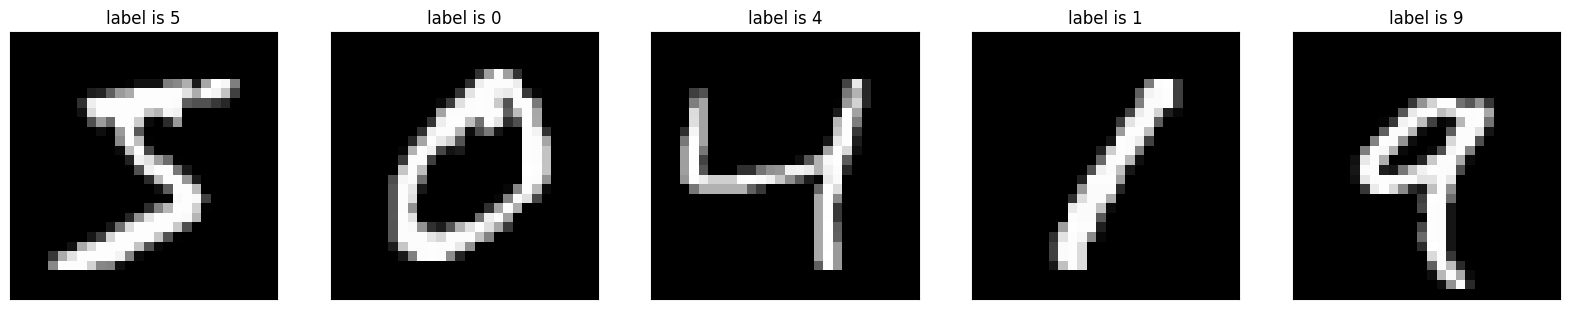

In [20]:
# 画像として見られるように配列の形を変更
X = np.reshape(X, (-1, 28, 28))

# 最初の5枚を確認してみる
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    axs[i].imshow(X[i], cmap="gray")
    axs[i].set_title("label is {:d}".format(y[i]))
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

上の結果を確認してみると「5」の手書き画像に対して"5"というラベルが対応していることが分かる。以後は、このデータを使って数字の認識を試みる。

なお、上記のデータは訓練用のデータが60000枚、テスト用のデータが10000で合計70000のデータとなっているため、以下のコードで訓練用とテスト用のデータを分けておく。

In [21]:
from sklearn import model_selection
X_train, X_test = model_selection.train_test_split(X, train_size=60000, test_size=10000, shuffle=False)
y_train, y_test = model_selection.train_test_split(y, train_size=60000, test_size=10000, shuffle=False)

## 主成分分析 (PCA)によるデータ分布の可視化

データを実際に分類する前に、784次元ベクトルを主成分分析(PCA = principal component analysis)で低次元ベクトルに変換して、データの分布がどのようになっているかを見てみよう。

主成分分析には共分散行列の固有ベクトルを利用するため、まずはデータ`X`から共分散行列を計算し、その固有ベクトルを求める。`numpy.linalg.eigh`で求められる固有ベクトルは固有値の絶対値が小さい順で並んでいるので、固有値が大きい方から2つに対応する固有ベクトルを取り出して、各数字の784次元ベクトルを2次元空間に射影してみる。

In [22]:
# 1次元ベクトルに直しておく
X_train = np.reshape(X_train, (-1, 784))  
# 共分散行列の計算
C_train = np.cov(X_train.T, bias=1)
# 固有値分解 (対象行列なのでeighを使う)
_, eigvec = np.linalg.eigh(C_train)
# 分散が最大の2方向を使って2次元空間に射影
Z_train = X_train @ eigvec[:, -2:]

これを各数字に別の色がつくようにMatplotlibを用いて可視化してみる。この際、何色がどの数字に対応するかが分かるように、`plt.legend`で凡例がつくようにしておこう。

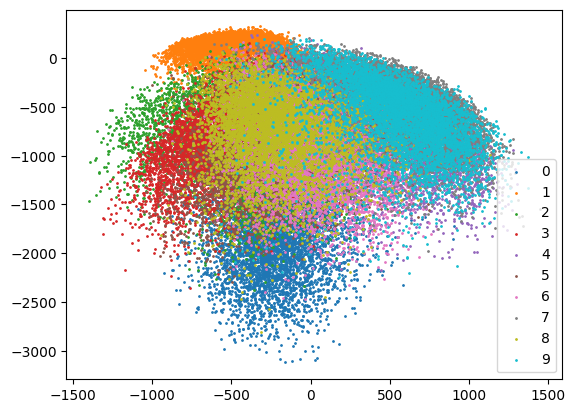

In [23]:
plt.figure()
for i in range(10):
    idx = np.where(y_train == i)
    plt.scatter(Z_train[idx, 0], Z_train[idx, 1], label=str(i), s=1)
plt.legend()
plt.show()

図を見てみると、概ね同じ数字が近くに集まってクラスタを形成していることが分かる。上図は2次元までベクトルを圧縮して作成しているため、数字同士の領域に大きな重複が見られるが、もう少し高い次元であれば、各数字の占める領域が重ならないようにすることができそうだ。

## Gauss混合分布 (GMM)による数字の分類